# Лабораторная работа по Relevance Vector Regression
В рамках этой лабораторной работы необходимо:
- Имплементировать Relevance Vector Regression
- Применить на синетическом датасете (восстановление полинома), сравнить с Lasso из sklearn и гребневой регрессией
- Применить на данных sinc с RBF признаками, визуализировать "релевантные вектора", сравнить с Support Vector Regression и Lasso
- Сделать выводы

In [275]:
import numpy as np
from matplotlib import pyplot as plt
from __future__ import print_function

%matplotlib inline
%config InlineBackend.figure_formats = ['svg']
np.random.seed(123)

def l2_error(X, t, w):
    return np.sum((X.dot(w.ravel()) - t) ** 2)

## Имплементация Relevance Vector Regression

Здесь необходимо реализовать три функции:

1. `get_w_sigma(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и возвращает параметры апостериорного распределения mu, sigma
2. `update_alpha_beta(X, t, alpha, beta)`, которая принимает датасет (X, t) и гиперпараметры RVR (alpha, beta) и делает один шаг итерационной процедуры для обновления гиперпараметров (было на лекции)
3. `fit_rvr(X, t, max_iters)`, которая принимает датасет (X, t) и максимальное количество итераций и возвращает обученные гиперпараметры и параметры апостериорного распределения на веса модели

На что стоит обратить внимание:

1. Результаты дорогостоящих операций типа перемножения одних и тех же матриц нужно кешировать и переиспользовать
2. $\alpha$-ы для нерелевантных объектов должны принять значение `np.inf`, а соответствующие веса и их дисперсии должны иметь значение 0
3. Бесконечности и нули из предыдущего пункта должны обрабатываться корректно, без NaN-ов и warning-ов
4. Матрицу с бесконечными элементами на диагонали можно обращать более эффективно (достаточно обратить подматрицу)

In [276]:
def get_w_sigma(X, t, alpha, beta):
    """Calculate the mean and the covariance matrix
       of the posterior distribution"""
    n, d = X.shape
    sigma = np.zeros((d, d))
    w = np.zeros(d)
    
    ind = ~np.isinf(alpha)
    
    sigma[np.ix_(ind, ind)] = np.linalg.inv(beta * X.T[ind, :] @ X[:, ind] + np.diag(alpha[ind]))
    w[ind] = beta * sigma[np.ix_(ind, ind)] @ X.T[ind, :] @ t
    
    return w, sigma

def update_alpha_beta(X, t, alpha, beta, eps=1e-7):
    """Update the hyperperemeters to increase evidence"""
    n, d = X.shape
    w, sigma = get_w_sigma(X, t, alpha, beta)
    
    ind_no_inf = ~np.isinf(alpha)
    ind_no_zeros = np.absolute(w) > eps
    ind = ind_no_inf * ind_no_zeros
    
    tmp = 1 - alpha[ind] * np.diag(sigma[np.ix_(ind, ind)])
    
    alpha_new = np.full(d, np.inf)
    
    alpha_new[ind] = tmp / w[ind] ** 2
    beta_new = (n - sum(tmp)) / np.linalg.norm(t - X[:, ind] @ w[ind]) ** 2
    
    return alpha_new, beta_new

def fit_rvr(X, t, max_iter=10000):
    """Train the Relevance Vector Regression model"""
    n, d = X.shape
    
    alpha, beta = np.ones(d), 1
    
    for it in range(max_iter):
        alpha, beta = update_alpha_beta(X, t, alpha, beta) 
        
    w, sigma = get_w_sigma(X, t, alpha, beta)
    
    return w, sigma, alpha, beta

## Восстановление полинома

Здесь решается модельная задача: зашумленным полиномом третьей степени сгенерированы данные для задачи регрессии. Нужно на этих данных обучить многочлен степени, не превышающей 20. Предлагается сравнить три модели: гребневую регрессию, L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных признаков.

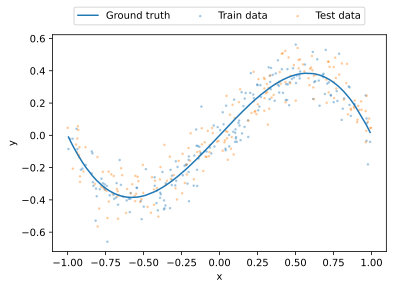

In [277]:
# Data generation

def gen_batch(n, w, beta):
    d = len(w)
    X = np.random.uniform(-1, 1, (n, 1))
    X = np.sort(X, axis=0)
    X = np.hstack([X ** i for i in range(d)])
    t = X.dot(w) + np.random.normal(size=n) / beta ** 0.5
    return X, t

n = 200
d = 21
w_true = np.zeros(d)
w_true[1] = 1
w_true[3] = -1
beta_true = 100

X_train, t_train = gen_batch(n, w_true, beta_true)
X_test, t_test = gen_batch(n, w_true, beta_true)

# Visualization
fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [278]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

In [279]:
# Ridge Regression with Cross-Validation
from sklearn.linear_model import RidgeCV
ridge = RidgeCV(cv=20, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False).fit(X_train, t_train)
w_ridge = ridge.coef_

In [280]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV, Lasso
lasso = LassoCV(cv=5, alphas=10.**np.linspace(-6, 3, 100),
                fit_intercept=False, max_iter=2000000).fit(X_train, t_train)
w_lasso = lasso.coef_

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:526: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.006909795579468803, tolerance: 0.0012854460800422096
  model = cd_fast.enet_coordinate_descent_gram(


Relevance Vector Regression
Features remaining: 3 / 21
Train error: 0.00905279670930489
Test error:  0.009793464126595361
--------------------------------------------------
Ridge Regression
Features remaining: NA (no sparsity)
Train error: 0.00909503455322363
Test error:  0.009961442053083665
--------------------------------------------------
Lasso Regression
Features remaining: 9 / 21
Train error: 0.0088789635474695
Test error:  0.010139505424318336


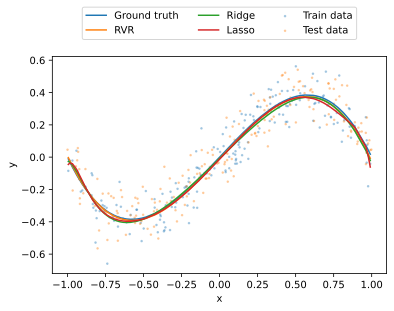

In [281]:
# Comparison
print('Relevance Vector Regression')
print('Features remaining:', np.sum(alpha_rvr < 1e8), '/', d)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Ridge Regression')
print('Features remaining: NA (no sparsity)')
print('Train error:', l2_error(X_train, t_train, w_ridge) / n)
print('Test error: ', l2_error(X_test, t_test, w_ridge) / n)
print('-'*50)
print('Lasso Regression')
print('Features remaining:', np.sum(np.abs(w_lasso) > 1e-20), '/', d)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)

fig, ax = plt.subplots()
ax.scatter(X_train[:, 1], t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(X_test[:, 1], t_test, s=3, label='Test data', alpha=0.3)
ax.plot(X_train[:, 1], X_train.dot(w_true), label='Ground truth')
ax.plot(X_train[:, 1], X_train.dot(w_rvr), label='RVR')
ax.plot(X_train[:, 1], X_train.dot(w_ridge), label='Ridge')
ax.plot(X_train[:, 1], X_train.dot(w_lasso), label='Lasso')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Регрессия с RBF-признаками

Здесь решается другая модельная задача: необходимо восстановить зашумленную функцию `sinc(x)`. Предлагается применить kernel trick с RBF-ядром (можно использовать функцию `sklearn.metrics.pairwise.rbf_kernel`), обучить три модели: SVM-регрессию (SVR), L1-регрессию (Lasso) и RVR, и сравнить ошибку на тестовой выборке и качество отобранных опорных / релевантных объектов.

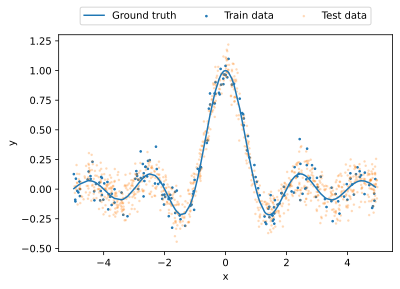

In [282]:
# Data generation
from sklearn.metrics.pairwise import rbf_kernel

def gen_batch(n, beta):
    points = np.random.uniform(-5, 5, n)
    points = np.sort(points)
    t = np.sinc(points) + np.random.normal(size=n) / beta ** 0.5
    return points, t

n = 200
n_test = 1000
d = n + 1
beta_true = 100

points_train, t_train = gen_batch(n, beta_true)
points_test, t_test = gen_batch(n_test, beta_true)

# RBF-transform
X_train = rbf_kernel(points_train.reshape(-1,1), points_train.reshape(-1,1))
X_test = rbf_kernel(points_test.reshape(-1,1), points_train.reshape(-1,1))

# Constant feature
X_train = np.hstack((np.ones((n, 1)), X_train))
X_test = np.hstack((np.ones((n_test, 1)), X_test))

# Visualization
fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=1)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.2)
ax.plot(points_train, np.sinc(points_train), label='Ground truth')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.15))
plt.show()

In [283]:
# Relevance Vector Regression
w_rvr, sigma_rvr, alpha_rvr, beta_rvr = fit_rvr(X_train, t_train)

In [284]:
# Lasso Regression with Cross-Validation
from sklearn.linear_model import LassoCV
lasso = LassoCV(cv=10, alphas=10.**np.linspace(-5, 1, 20),
                fit_intercept=False, max_iter=100000, tol=1e-2, n_jobs=10).fit(X_train, t_train)
w_lasso = lasso.coef_

In [285]:
# Support Vector Regression
from sklearn.svm import SVR
svr = SVR(gamma=1, tol=1e-6, C=1).fit(points_train.reshape(-1, 1), t_train)

Relevance Vector Regression
Objects remaining: 8 / 200
Train error: 0.007990587212897263
Test error:  0.054087883258008125
--------------------------------------------------
Lasso Regression
Objects remaining: 63 / 200
Train error: 0.00944793599324124
Test error:  0.057053745050616646
--------------------------------------------------
Support Vector Regression
Objects remaining: 59 / 200
Train error: 0.008025458610972388
Test error:  0.05380995575776096


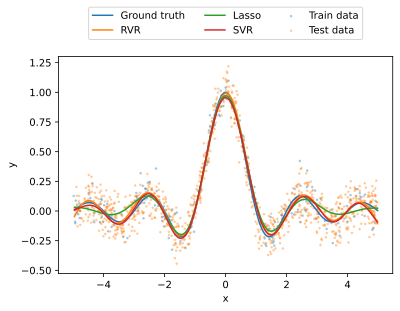

In [286]:
# Comparison
print('Relevance Vector Regression')
print('Objects remaining:', np.sum(alpha_rvr[1:] < 1e8), '/', n)
print('Train error:', l2_error(X_train, t_train, w_rvr) / n)
print('Test error: ', l2_error(X_test, t_test, w_rvr) / n)
print('-'*50)
print('Lasso Regression')
print('Objects remaining:', np.sum(np.abs(w_lasso[1:]) > 1e-20), '/', n)
print('Train error:', l2_error(X_train, t_train, w_lasso) / n)
print('Test error: ', l2_error(X_test, t_test, w_lasso) / n)
print('-'*50)
print('Support Vector Regression')
print('Objects remaining:', len(svr.support_), '/', n)
print('Train error:', np.sum((svr.predict(points_train.reshape(-1, 1)) - t_train) ** 2) / n)
print('Test error: ', np.sum((svr.predict(points_test.reshape(-1, 1)) - t_test) ** 2) / n)

fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.plot(points_test, X_test.dot(w_rvr), label='RVR')
ax.plot(points_test, X_test.dot(w_lasso), label='Lasso')
ax.plot(points_test, svr.predict(points_test.reshape(-1, 1)), label='SVR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

### Визуализация релевантных объектов для RVR

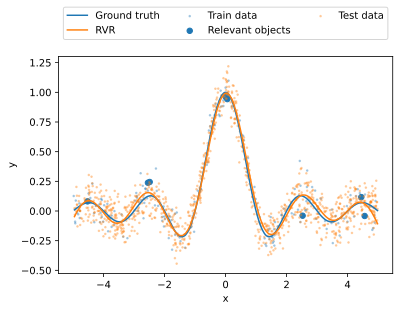

In [287]:
relevant = alpha_rvr[1:] < 1e8
fig, ax = plt.subplots()
ax.scatter(points_train, t_train, s=3, label='Train data', alpha=0.3)
ax.scatter(points_train[relevant], t_train[relevant], c='tab:blue', s=30, label='Relevant objects')
ax.scatter(points_test, t_test, s=3, label='Test data', alpha=0.3)
ax.plot(points_test, np.sinc(points_test), label='Ground truth')
ax.plot(points_test, X_test.dot(w_rvr), label='RVR')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend(ncol=3, loc=9, bbox_to_anchor=(0.5, 1.25))
plt.show()

## Выводы
* В первом эксперименте RVR показал наименьшую ошибку среди 3-х методов, во втором эксперименте незначительно уступил SVR (хотя выбрал гораздо меньше (релевантных/опорных) объектов).


* Что касается переобучения: RVR переобучается меньше остальных моделей. Это отчетливо видно, если сранивать модель с Lasso.


* Из первого эксперимента следует, что RVR оставляет наименьшее количество признаков - 3/21, а из второго: что RVR оставляет наименьшее количество (релевантных) объектов - 8/200, причем эти объекты хорошо интерпретируются и  в основном соответствуют максимумам аппроксируемой функции.


* В обоих экспериментах RVR хорошо справилась с решением задачи.